In [1]:
import os
import cv2
import torch
import warnings
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings(action = 'ignore')

In [2]:
class CT_dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        self.len = len(self.X)
        return self.len
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx]).float()
        Y = self.Y[idx]
        return X,Y
    
class DataManager():
    def __init__(self, files, batch_size, train, transform):
        self.files       = files
        self.batch_size  = batch_size
        self.train       = train
        self.transform   = transform
                
    def Load_Dataset(self):
        X = []
        Y = []
        for file in self.files:
            X.append(self.transform(cv2.imread(file)))
            Y.append(file.split('/')[-1].split('.')[0])    
        X = np.array(X)
        Y = np.array(Y)
        data = CT_dataset(X, Y)
        return data
    
    def Load_DataLoader(self, data):
        if self.train == True:
            return DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        else:
            return DataLoader(data, batch_size=self.batch_size, shuffle=False, drop_last=False)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
path      = './dataset/'
types     = ['normal/', 'moderate/', 'severe/']
files     = []
for type_ in types:
    for id_ in os.listdir(path+type_):
        for file in os.listdir(path+type_+id_+'/axial'):
            files.append(path+type_+id_+'/axial/'+file)

In [4]:
TEST_DM       = DataManager(files = files, batch_size=512, train=False, transform=transform)
TEST_DATA     = TEST_DM.Load_Dataset()
TEST_LOADER   = TEST_DM.Load_DataLoader(TEST_DATA)

In [5]:
model = models.resnet50(pretrained=True)

In [6]:
def custom_forward(model, X):
    out = model.conv1(X)
    out = model.bn1(out)
    out = model.relu(out)
    out = model.maxpool(out)
    out = model.layer1(out)
    out = model.layer2(out)
    out = model.layer3(out)
    out = model.layer4(out)
    out = model.avgpool(out)
    return out
    

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() == True else 'cpu'
model.to(DEVICE)
model.eval()
features   = []
labels     = []

for idx, batch in enumerate(TEST_LOADER):
    X, Y = batch
    X    = X.to(DEVICE)
    Y_pred = custom_forward(model, X).squeeze()
    features.append(Y_pred.detach().numpy())
    labels.append(Y)

features_ = np.vstack(np.array(features))
labels_   = np.array(labels)

RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 24.00 GiB total capacity; 21.63 GiB already allocated; 0 bytes free; 21.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
label_dict = {}
cmap       = plt.get_cmap('inferno')

In [ ]:
tsne = TSNE(random_state=0)

tsne_result = tsne.fit_transform(features_)

(1133, 2048) (1133,)


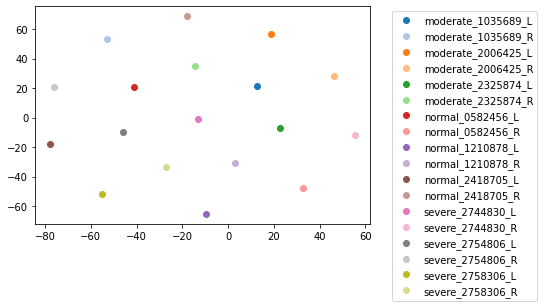

In [14]:
import os
import cv2
import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings(action = 'ignore')

class CT_dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        self.len = len(self.X)
        return self.len
    
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx]).float()
        Y = self.Y[idx].split(' ')[0]
        return X,Y
    
class DataManager():
    def __init__(self, files, batch_size, train, transform):
        self.files       = files
        self.batch_size  = batch_size
        self.train       = train
        self.transform   = transform
                
    def Load_Dataset(self):
        X = []
        Y = []
        for file in self.files:
            X.append(self.transform(cv2.imread(file)))
            #Y.append(file.split('/')[-4] + '_' +file.split('/')[-3])   # -> full image일 경우
            Y.append(file.split('/')[-2] + '_' +file.split('/')[-1].split('.')[0].split('_')[-1])
        X = np.array(X)
        Y = np.array(Y)
        data = CT_dataset(X, Y)
        return data
    
    def Load_DataLoader(self, data):
        if self.train == True:
            return DataLoader(data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        else:
            return DataLoader(data, batch_size=self.batch_size, shuffle=False, drop_last=False)
        
def custom_forward(model, X):
    out = model.conv1(X)
    out = model.bn1(out)
    out = model.relu(out)
    out = model.maxpool(out)
    out = model.layer1(out)
    out = model.layer2(out)
    out = model.layer3(out)
    out = model.layer4(out)
    out = model.avgpool(out)
    return out
    
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# path      = './dataset/'
# types     = ['normal/', 'moderate/', 'severe/'] #-> full image 경우 이걸로
# files     = []
# for type_ in types:
#     for id_ in os.listdir(path+type_):
#         for file in os.listdir(path+type_+id_+'/axial'):
#             files.append(path+type_+id_+'/axial/'+file)

path  = './crop_fliped_filtered/'
files = []
for folder in os.listdir(path):
    for file in os.listdir(path+folder):
        files.append(path+folder+'/'+file)
            
TEST_DM       = DataManager(files = files, batch_size=128, train=False, transform=transform)
TEST_DATA     = TEST_DM.Load_Dataset()
TEST_LOADER   = TEST_DM.Load_DataLoader(TEST_DATA)

model = models.resnet50(pretrained=True)

DEVICE = 'cuda' if torch.cuda.is_available() == True else 'cpu'
model.to(DEVICE)
model.eval()
features   = []
labels     = []

for idx, batch in enumerate(TEST_LOADER):
    X, Y = batch
    X    = X.to(DEVICE)
    Y_pred = custom_forward(model, X).squeeze()
    features.append(Y_pred.cpu().detach().numpy())
    labels.append(Y)

features_ = np.vstack(np.array(features))
labels_   = np.hstack(np.array(labels))

feature_mean = []
print(features_.shape, labels_.shape)

label_dict   = {}
for label_ in labels_:
    if label_ not in label_dict.keys():
        label_dict[label_] = 1

for key in label_dict.keys():
    feature_mean.append(features_[labels_ == key,:].mean())

feature_mean = np.array(feature_mean).reshape(-1,1)

tsne = TSNE(random_state=0)

tsne_result = tsne.fit_transform(feature_mean)

df = pd.DataFrame({'x':[],
                   'y':[],
                   'z':[]})
for idx, result in enumerate(tsne_result):
    df = df.append({'x':result[0], 'y':result[1], 'z':list(label_dict.keys())[idx]}, ignore_index=True)

groups = df.groupby('z')

ccc = []
cmap = plt.get_cmap('tab20')
c_count = 0
for idx, color in enumerate(cmap.colors):
    ccc.append(list(cmap.colors[idx]))
    ccc[idx].append(1.0)
color_map = np.array(ccc)

for name, group in groups:
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=12, label=name, c = color_map[c_count][:4])
    c_count += 1
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()